# Setup

In [ ]:
# This code chunk can be removed in the final notebook since the requirements.txt file lists all used packages!
!pip install requests openpyxl PyMuPDF glob2 nltk spacy pandas gensim Counter matplotlib seaborn wordcloud pmdarima statsmodels

In [2]:
# accessing APIs and URLs
import requests

# static web scraping
from urllib.request import urlopen
from lxml.html import parse, fromstring

# regular expressions
import re

# downloading files
import urllib.request

# operating system
import os

# looping through folder
import glob

# reading pdfs
import fitz 

# disabling warnings
import warnings

# nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# nlp
import spacy

# data wrangling
import pandas as pd

# topic modelling
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# counting words
from collections import Counter

# data viz
import matplotlib.pyplot as plt

# grahps
import seaborn as sns

# word cloud
from wordcloud import WordCloud

# centering plots
from IPython.core.display import HTML

# merging multiple data frames
from functools import reduce

# automated time series analysis
import pmdarima as pm

# ARIMA
from statsmodels.tsa.arima.model import ARIMA

# ignoring warnings
warnings.filterwarnings('ignore')

In [ ]:
# download trained pipeline for the English language
!python3 -m spacy download en_core_web_sm

# download dictionary
nltk.download('omw-1.4')
nltk.download('wordnet')

In [4]:
# center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Data Collection and Import

In [5]:
# extract all links from website
tree = parse(urlopen("https://www.americanrhetoric.com/barackobamaspeeches.htm"))
linkelements = tree.xpath("//a")
list_links = [e.attrib["href"] for e in linkelements]

In [6]:
print("Number of links: " + str(len(list_links)))

Number of links: 1417


In [7]:
# only retain pdf links
p = re.compile('.*pdf$')
pdf_links = [ s for s in list_links if p.match(s) ]

In [8]:
print("Number of pdf links: " + str(len(pdf_links)))

Number of pdf links: 436


In [9]:
# concetenate baseurl and path
baseurl = "https://www.americanrhetoric.com/"
full_pdf_links = [baseurl + link for link in pdf_links]

In [10]:
# create new folder
folder_name = "obama_speeches"
os.makedirs(folder_name, exist_ok = True)

In [11]:
# download all pdf files
def download_files(links, folder):
    i = 1
    for link in links:
        filename = folder + "/file_" + str(i) + ".pdf"
        
        # check if file already exists and, if so, continue
        if os.path.isfile(filename):
            continue
            
        # otherwise download file and save in folder
        else: 
            urllib.request.urlretrieve(link, filename)
        
        i = i + 1

In [12]:
download_files(full_pdf_links, folder_name)

In [13]:
# import files
def import_pdfs(folder):
    
    # sort pdf files by name
    numbers = re.compile(r'(\d+)')
    def numericalSort(value):
        parts = numbers.split(value)
        parts[1::2] = map(int, parts[1::2])
        return parts
    filename_list = sorted(glob.glob(folder + "/*.pdf"), key = numericalSort)
    
    # create empty list
    speech = []
    
    # loop through all files
    for filename in filename_list:
        with fitz.open(filename) as doc:
            text = ""
            for page in doc:
                text += page.get_text()
        speech.append(text)
        
    return speech

In [14]:
list_speeches = import_pdfs(folder_name)

# Data Pre-Processing

## Noise Removal

In [15]:
# noise removal and standardisation
def noise_removal(texts):
    no_noise = []
    for text in texts:
        
        # separate line breaks from words
        p1 = re.compile(r'(\n)([A-Za-z\\[])') 
        text = re.sub(p1, r"\1 \2", text) 
        p2 = re.compile(r'([A-Za-z])(\n)') 
        text = re.sub(p2, r"\1 \2", text)
        
        # remove footer
        text = re.sub('(AAm|AmericanRhetoric\.com)\s((.||\n)*?)\sPage\s\d{1,2}', '', text)
        text = re.sub('(meerriiccaannR)\s((.||\n)*?)\s(Property)', '', text)
        
        # remove everything up until (and including) the sentence with the date of the speech
        text = re.sub(r'^((.|\n)*)\s(\d{1,2}\s{1,2}[a-zA-Z]{3,9},?\s\d{4},?)\s.*\s\n', '', text)  
        
        # remove everything up until (and including) the statement about transcription
        text = re.sub('^((.|\n)*)\s(\\[?AUTHENTICITY)\s.*\s\n', '', text)  
        
        # remove line breaks
        text = re.sub("\n", "", text) 
        
        # remove multiple white spaces
        text = re.sub("\s+", " ", text) 
        
        # lower case
        text = text.lower() 
        
        # remove punctuation and most special characters
        text = re.sub("[^a-zA-Z\d\s/]", "", text)
        no_noise.append(text)
        
    return no_noise

In [16]:
no_noise = noise_removal(list_speeches)

In [17]:
# stopword removal
stop_words = stopwords.words("english")
no_stopwords = [[word for word in word_tokenize(text) if word not in stop_words] for text in no_noise]

## N-Grams

In [18]:
# create n-grams
def n_grams(texts, min_count, threshold):
    
    # setup
    bigram = gensim.models.Phrases(texts, min_count = min_count, threshold = threshold)
    trigram = gensim.models.Phrases(bigram[texts], threshold = threshold)  
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # add bigrams
    n_grams = [bigram_mod[doc] for doc in texts]

    # add trigrams
    n_grams = [trigram_mod[bigram_mod[doc]] for doc in texts]
    
    return n_grams

In [19]:
bigrams_trigrams = n_grams(no_stopwords, 5, 100)

## Text Normalisation

In [20]:
# text normalisation with pos tags
def text_normalisation(texts):
    nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
    postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    normalised_data = []

    for word in texts:
            doc = nlp(" ".join(word)) 
            normalised_data.append([token.lemma_ for token in doc if token.pos_ in postags])
    
    return normalised_data

In [21]:
normalised_data = text_normalisation(bigrams_trigrams)

## Removal of Low and High Frequency Words

In [22]:
# compute vocabulary size
def count_words(texts):
    count_words = Counter([i for sublist in texts for i in sublist])
    return count_words

def print_vocab_size(texts):
    print("Total Vocabulary Size: " + str(len(texts)))

In [23]:
count_words_pre_cleaning = count_words(normalised_data)
print_vocab_size(count_words_pre_cleaning)

Total Vocabulary Size: 17831


In [24]:
# compute word frequencies
dict_df = pd.DataFrame.from_dict(count_words_pre_cleaning, orient = 'index', columns = ['freq'])
dict_df['perc'] = (dict_df['freq'] / dict_df['freq'].sum()) * 100
dict_df.sort_values('perc', ascending = False).head(15).round(2)

,freq,perc
s,7609,1.26
people,7420,1.23
go,6762,1.12
make,6714,1.11
ve,6256,1.04
get,5915,0.98
work,4542,0.75
say,4374,0.72
country,3959,0.66
think,3695,0.61


In [25]:
# add low and high frequency words to stop_words
min_freq = 20; max_freq = 2300
extension = dict_df[(dict_df.freq <= min_freq) | (dict_df.freq >= max_freq)].index.tolist()
extension = extension + ["lot", "thing", "let", "use", "sure", "look", "tell", "many", "much", "thank"]
stop_words.extend(extension)

# remove stopwords
stop_words_extended = set(stop_words)
cleaned_data = [[token for token in text if token not in stop_words_extended] for text in normalised_data]

# compute vocabulary size
count_words_post_cleaning = count_words(cleaned_data)
print_vocab_size(count_words_post_cleaning)

Total Vocabulary Size: 2946


In [26]:
# create term document frequency
id2word = corpora.Dictionary(cleaned_data)
corpus = [id2word.doc2bow(text) for text in cleaned_data]

# Topic Modelling

## Determining the Number of Topics

In [27]:
# 'elbow' method
def coherence_values(corpus, id2word, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = num_topics, 
                                          random_state = 100, update_every = 1, chunksize = 100, 
                                          passes = 10, alpha = 'auto', per_word_topics = True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = cleaned_data, dictionary = id2word, 
                                        coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return coherence_values

In [28]:
start = 2; limit = 20; step = 2
coherence_values = coherence_values(corpus, id2word, start, limit, step)

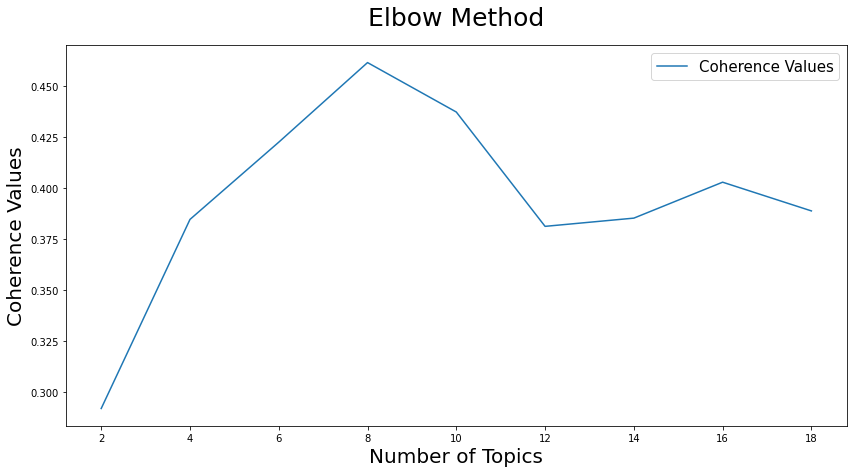

In [29]:
# plot results
plt.rcParams['figure.figsize'] = [14, 7]
x = range(start, limit, step)
plt.plot(x, coherence_values, label = "Coherence Values")
plt.xlabel("Number of Topics", fontsize = 20)
plt.ylabel("Coherence Values", fontsize = 20)
plt.legend(loc="upper right", fontsize = 15)
plt.title('Elbow Method', fontsize = 25, pad = 20)
plt.show()

In [30]:
# examine coherence values
for number_topics, cv in zip(x, coherence_values):
    print(number_topics, 'topics have a coherence value of', round(cv, 3))

2 topics have a coherence value of 0.292
4 topics have a coherence value of 0.385
6 topics have a coherence value of 0.422
8 topics have a coherence value of 0.462
10 topics have a coherence value of 0.437
12 topics have a coherence value of 0.381
14 topics have a coherence value of 0.385
16 topics have a coherence value of 0.403
18 topics have a coherence value of 0.389


Based on the coherence values, 8 topics seem to be the best choice for our data. However, a coherence value of 0.462 is rather low, so maybe more pre-processing is needed?

## Latent Dirichlet Allocation

In [31]:
# build topic model
number_topics = 8
topic_model_lda = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = number_topics, 
                                                  random_state = 100, update_every = 1, chunksize = 100, 
                                                  passes = 14, alpha = 'auto', per_word_topics = True)

In [32]:
# compute perplexity
print('Perplexity: ', round(topic_model_lda.log_perplexity(corpus), 3))

# compute coherence value
coherence_topic_model_lda = CoherenceModel(model = topic_model_lda, texts = cleaned_data, dictionary = id2word, 
                                           coherence = 'c_v')
coherence_topic_model_lda_values = coherence_topic_model_lda.get_coherence()
print('Coherence Value: ', round(coherence_topic_model_lda_values, 3))

Perplexity:  -7.123
Coherence Value:  0.464


interpretation??

In [33]:
# create data frame of topics with corresponding keywords
lda_topics = [[(term, round(weight, 3)) for term, weight in topic_model_lda.show_topic(n, topn = 20)] 
              for n in range(0, topic_model_lda.num_topics)]
lda_topics_df = pd.DataFrame([', '.join([term for term, weight in topic]) 
                              for topic in lda_topics], columns = ['keywords'],
                             index = ['topic_' + str(t) for t in range(1, topic_model_lda.num_topics + 1)] )

In [34]:
# replace generic index with topic names
index_names = lda_topics_df.index.values.tolist()
topic_names = ["defence", "national pride", "labour market", "health care", "financial sector", 
               "support system", "future", "political ambitions"]
lda_topics_df = lda_topics_df.rename(index = dict(zip(index_names, topic_names)))

In [35]:
# print data frame
pd.set_option('display.max_colwidth', 0)
lda_topics_df

,keywords
defence,"isil, military, terrorist, war, security, continue, threat, american, support, force, nation, attack, effort, government, include, united_state, troop, fight, today, protect"
national pride,"united_state, nation, young, together, democracy, believe, government, future, today, global, opportunity, economy, progress, leader, region, great, live, strong, peace, security"
labour market,"job, economy, business, company, pay, create, american, family, today, worker, government, put, cut, future, education, reform, plan, last, keep, back"
health care,"insurance, cost, law, plan, pay, system, obamacare, coverage, even, money, provide, republican, medicare, health_insurance, health_care, affordable_care_act, fact, idea, keep, state"
financial sector,"firm, fee, excess, trigger, bonus, financial_institution, turmoil, massive, executive, shareholder, taxpayer, abuse, bank, reform, financial, bailout, wall_street, soar, mutual, owe"
support system,"family, life, day, love, today, give, nation, great, man, home, live, service, even, serve, veteran, american, lose, honor, keep, gun"
future,"change, child, believe, today, life, democracy, woman, give, nation, faith, young, hard, history, live, hope, man, story, never, generation, understand"
political ambitions,"question, issue, try, president_obama, important, happen, president, able, talk, start, deal, really, part, continue, give, fact, problem, point, even, election"


In [36]:
# reset display settings
pd.reset_option('^display.', silent = True)

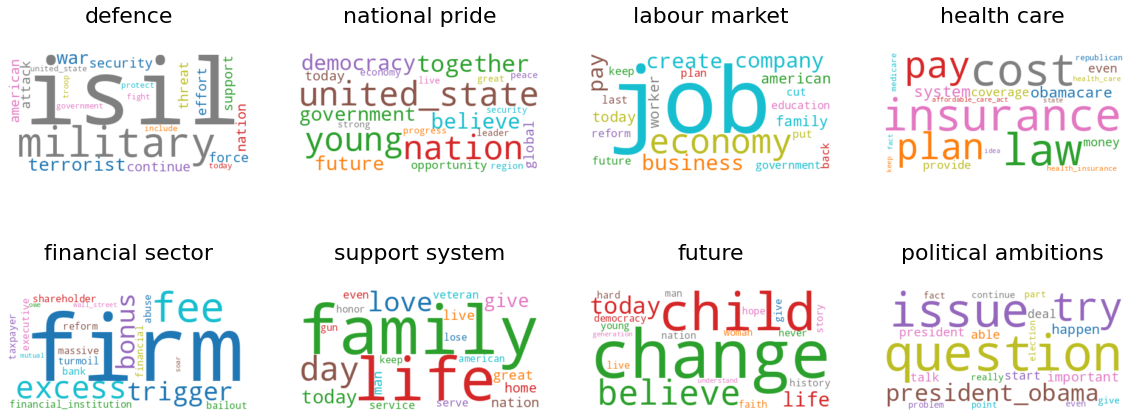

In [37]:
# plot settings
wc = WordCloud(background_color = "white", colormap = "tab10",
               max_font_size = 150, random_state = 42)
plt.rcParams['figure.figsize'] = [20, 8]

# create wordcloud for each topic
for i in range(topic_model_lda.num_topics):
    wc.generate(text = lda_topics_df["keywords"][i])
    plt.subplot(2, 4, i + 1)
    plt.imshow(wc, interpolation = "bilinear")
    plt.axis("off")
    plt.title(lda_topics_df.index[i], fontsize = 22, y = 1.2)

## Topic Distribution by Years

In [38]:
# extract distribution of topics by speech
topic_distribution_speeches = [topic_model_lda.get_document_topics(item, 
                                                                   minimum_probability = 0.0) for item in corpus]

In [39]:
# create data frame of topic distributions by speech
lda_df_proportions = pd.DataFrame.from_records([{v: k for v, k in row} for row in topic_distribution_speeches])
lda_df_proportions.columns = topic_names
lda_df_proportions['file'] = lda_df_proportions.reset_index().index + 1
lda_df_proportions = lda_df_proportions.set_index('file')

In [40]:
# create data frame of speeches
d = {'speech': list_speeches}
speeches_df = pd.DataFrame(d)

# add file name
speeches_df['file'] = speeches_df.reset_index().index + 1
speeches_df = speeches_df.set_index('file')

# extract dates of speeches
date_reg = r'(\d{1,2}\s{1,2}[a-zA-Z]{3,9},?\s?\d{4}?)'
speeches_df['date'] = speeches_df['speech'].str.extract(date_reg, expand = False)

# manually fix dates that were not picked up by regex
speeches_df.at[271, 'date'] = '2014-07-18'
speeches_df.at[329, 'date'] = '2015-07-15'
speeches_df.at[377, 'date'] = '2016-02-26'
speeches_df['date'] = pd.to_datetime(speeches_df['date'])

# drop speech column
speeches_df = speeches_df.drop('speech', 1)

In [41]:
# merge both data frames
df_merged = pd.merge(lda_df_proportions, speeches_df, on = 'file')

In [42]:
# extract year of speeches
df_merged['year'] = df_merged['date'].dt.year.convert_dtypes()

# average topic distribution per year
topic_distribution_df = df_merged.groupby('year', as_index = False)[topic_names].mean().copy()

# transform data frame from wide to long format
topic_distribution_df_melt = topic_distribution_df.melt(id_vars = 'year', value_vars = topic_names, 
                                                        var_name = 'topic', value_name = 'prevelance')

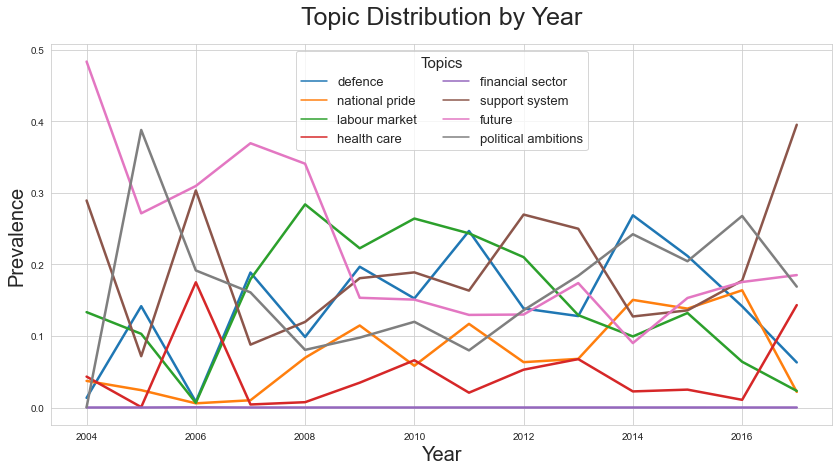

In [43]:
# plot topic distribution by year
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [14, 7]
topics_by_year = sns.lineplot(data = topic_distribution_df_melt, x = "year", y = "prevelance", hue = "topic",
                              linewidth = 2.5)
topics_by_year.set_xlabel("Year", fontsize = 20)
topics_by_year.set_ylabel("Prevalence", fontsize = 20)
plt.legend(ncol = 2, loc = 'upper center', fontsize = 13, title = "Topics", title_fontsize = 15, markerscale = 1.5)
plt.title('Topic Distribution by Year', fontsize = 25, pad = 20)
plt.show()

# Topic Prediction

## Predictors

In [44]:
# compute average topic distribution per month
df_merged['month_year'] = df_merged['date'].dt.to_period('M')
topic_distributions_monthly = df_merged.groupby('month_year', as_index = False)[topic_names].mean().copy()

# transform topic proportions to percentage points
topic_distributions_monthly.iloc[:, 1:8] = topic_distributions_monthly.iloc[:, 1:8] * 100

# convert date format
topic_distributions_monthly['month_year'] = topic_distributions_monthly['month_year'].dt.strftime('%Y-%m').add('-01')

In [45]:
# import monthly unemployment data
unemployment = pd.read_excel("other_data/unemployment_rate.xls", skiprows=10)
unemployment = unemployment.rename(columns={'UNRATE': 'unemployment', 'observation_date': 'month_year'})
unemployment = unemployment[(unemployment['month_year'] >= '2004-07-01') & (unemployment
                                                                    ['month_year'] <= '2017-01-01')]
unemployment['month_year'] = unemployment['month_year'].dt.strftime('%Y-%m-%d')

In [46]:
# import daily oil price data
oil = pd.read_csv("other_data/oil_prices.csv", skiprows = 6, parse_dates = ['Day'])
oil = oil.rename(columns = {'Europe Brent Spot Price FOB $/bbl': 'Brent', 
                          'Cushing OK WTI Spot Price FOB $/bbl': 'Cushing'})

# convert date format
oil['Day'] = pd.to_datetime(oil['Day'])
oil['month_year'] = oil['Day'].dt.to_period('M')
oil['month_year'] = oil['month_year'].dt.strftime('%Y-%m').add('-01')

# compute average monthly oil price
oil = oil.groupby('month_year', as_index = True)['Brent', 'Cushing'].mean().copy()
oil['oil'] = oil.mean(axis = 1)

# drop irrelevant columns
oil = oil.drop(['Brent', 'Cushing'], 1)

In [47]:
# import daily Dow Jones stock market data
stocks = pd.read_csv("other_data/HistoricalPricesDowJones.csv", usecols = ['Date', ' Close'], 
                     parse_dates = ['Date'])
stocks = stocks.rename(columns = {' Close': 'stocks'})

# convert date format
stocks['month_year'] = stocks['Date'].dt.to_period('M')
stocks['month_year'] = stocks['month_year'].dt.strftime('%Y-%m').add('-01')

# compute average monthly stock market index
stocks = stocks.groupby('month_year', as_index = True)['stocks'].mean().copy()

In [48]:
# merge data frames
data_frames = [topic_distributions_monthly, unemployment, oil, stocks]
time_series_df = reduce(lambda left, right: pd.merge(left, right, on = ['month_year'],
                                            how = 'inner'), data_frames)

# replace index with dates
time_series_df.index = pd.DatetimeIndex(time_series_df.month_year)
time_series_df.sort_index(inplace = True)
time_series_df = time_series_df.drop('month_year', 1)

time_series_df.astype(float).round(2).head(10)

,defence,national pride,labour market,health care,financial sector,support system,future,political ambitions,unemployment,oil,stocks
month_year,,,,,,,,,,,
2004-07-01,1.35,3.72,13.32,4.32,0.00,28.92,48.33,0.00,5.5,39.50,10152.09
2005-01-01,0.09,0.06,0.07,0.03,0.00,0.12,33.16,0.66,5.3,45.67,10539.51
2005-04-01,36.90,7.24,0.02,0.01,0.00,0.04,0.03,0.56,5.2,52.43,10283.19
2005-06-01,0.02,4.72,38.51,0.20,0.00,7.87,41.78,0.07,5.0,55.35,10486.68
2005-10-01,0.07,0.05,7.13,0.02,0.00,27.71,54.37,0.11,5.0,60.40,10324.31
2005-12-01,33.71,0.05,5.73,0.02,0.00,0.09,6.29,0.54,4.9,58.13,10827.79
2006-01-01,0.12,0.09,0.10,0.04,0.00,58.50,39.08,0.02,4.7,64.24,10872.48
2006-07-01,1.50,1.08,1.22,34.95,0.05,2.16,22.82,0.36,4.7,74.04,11032.53
2007-01-01,0.11,0.08,21.39,0.03,0.00,0.15,40.80,0.37,4.6,54.09,12512.89


## Time Series Analysis

In [61]:
# create train and test data
test_size = int(len(time_series_df) * 0.2)
train, test = time_series_df.iloc[:-test_size], time_series_df.iloc[-test_size:]

# standardise train data
def standardise_predictors(data):
    data = (data - data.mean()) / (data.std())
    return data

train_standardised = train.copy()
train_standardised.iloc[:, number_topics:] = standardise_predictors(train_standardised.iloc[:, number_topics:])

# standardise test data using train mean and train std
test_standardised = test.copy()
test_standardised.iloc[:, number_topics:] = (test_standardised.iloc[:, number_topics:] - train.iloc[:, number_topics:].
                                                      mean()) / (train.iloc[:, number_topics:].std())


### Model Taining

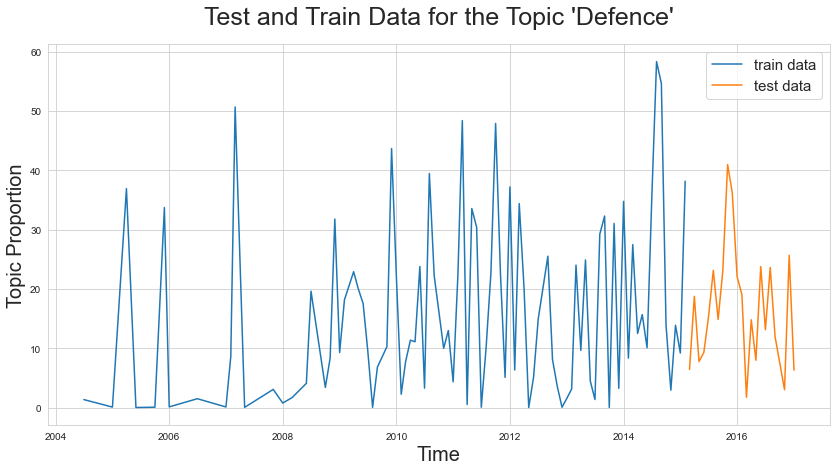

In [62]:
# plot test and train data for first topic (defence)
first_topic = topic_names[0]

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
ax.plot(train_standardised[first_topic], label = "train data")
ax.plot(test_standardised[first_topic], label = "test data")
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Topic Proportion", fontsize = 20)
plt.legend(loc = "upper right", fontsize = 15)
plt.title("Test and Train Data for the Topic '" + first_topic.title() + "'", fontsize = 25, pad = 20)
plt.show()

In [63]:
def time_series(data_set, predictors):
    # create empty list
    models = []
    i = 0
    
    # loop through topics and run automated time series analysis
    for column in data_set.columns[:number_topics]:        
        model = pm.auto_arima(data_set[[column]] , 
                          exogenous = data_set[predictors],
                          start_p = 1, 
                          start_q = 1,
                          test = 'adf',       
                          max_p = 5,          
                          max_q = 5,          
                          m = 1,              
                          d = None,           
                          seasonal = False,   
                          start_P = 0, 
                          D = 0, 
                          trace = False,             # suppress output
                          error_action = 'ignore',
                          suppress_warnings = True, 
                          stepwise = True)
    
        # append model to list
        models.append(model)
    
        i = i + 1
        
    return models

In [64]:
# select predictors
predictors = ['unemployment', 'oil', 'stocks']

# train time series model
models_train = time_series(train_standardised, predictors)

### Forecasting

In [65]:
# forecast time series and compare to test data
def forecast_time_series(models):
    i = 0
    for model in models:
        # predict time series
        prediction, confint = model.predict(n_periods = test_size, 
                                    exogenous = test_standardised[predictors],
                                    return_conf_int = True)
    
        # create index for prediction
        index_prediction = pd.date_range(train_standardised.index[-1], periods = test_size, freq='MS')
    
        # add index to forecast and corresponding confidence interval 
        fitted_series = pd.Series(prediction, index = index_prediction)
        lower_series = pd.Series(confint[:, 0], index = index_prediction)
        upper_series = pd.Series(confint[:, 1], index = index_prediction)
    
        print("\nThis is the forecast of the topic '" + topic_names[i] + "':\n")
    
        # plot forecast
        plt.plot(time_series_df[topic_names[i]])
        plt.plot(fitted_series, color = 'red')
        plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color = 'k', 
                 alpha = .1)
        plt.title("Forecast of Topic '" + str(topic_names[i]).title() + "'", fontsize = 25, pad = 20)
        plt.show()
    
        i = i + 1


This is the forecast of the topic 'defence':



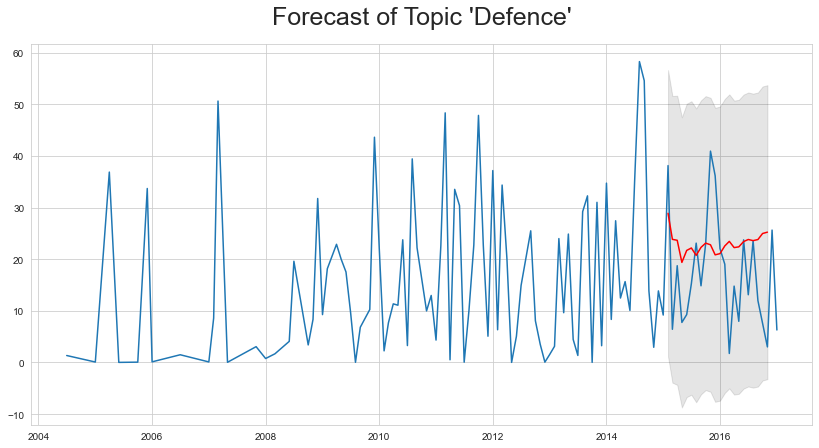


This is the forecast of the topic 'national pride':



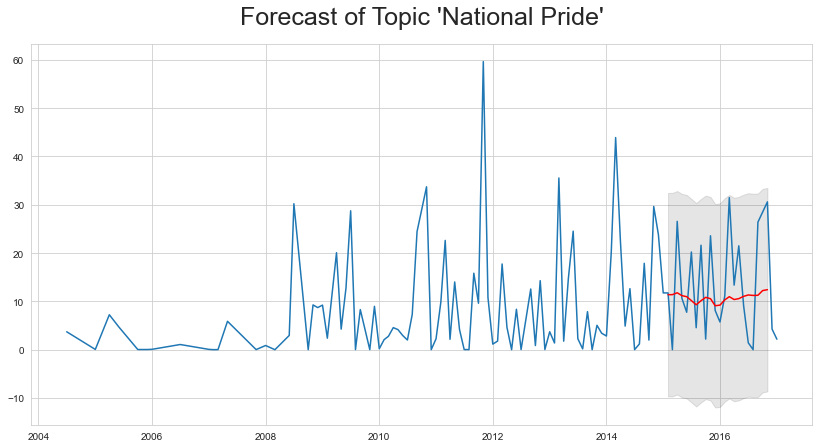


This is the forecast of the topic 'labour market':



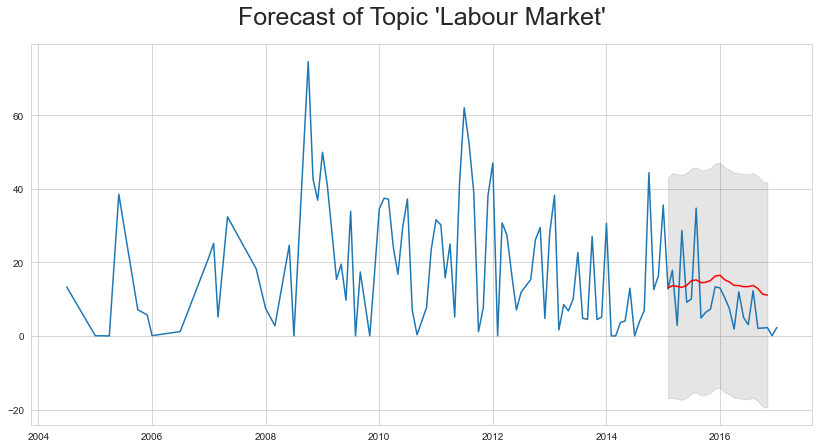


This is the forecast of the topic 'health care':



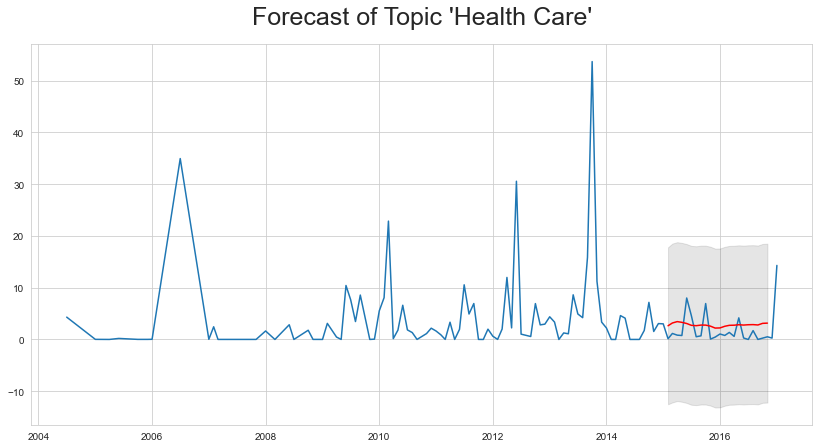


This is the forecast of the topic 'financial sector':



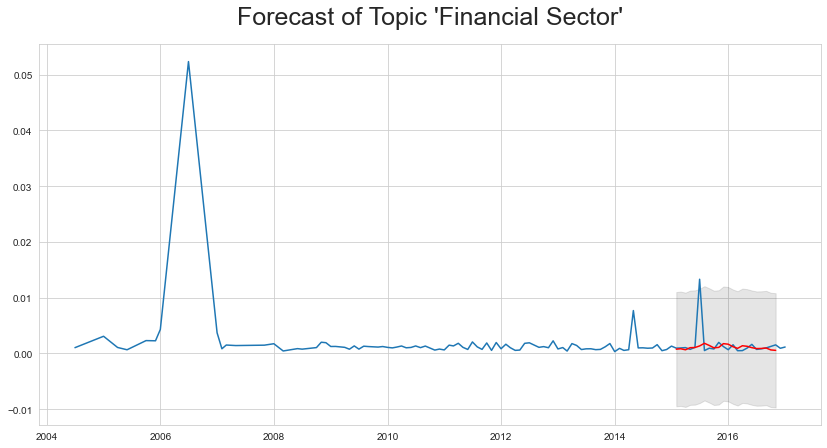


This is the forecast of the topic 'support system':



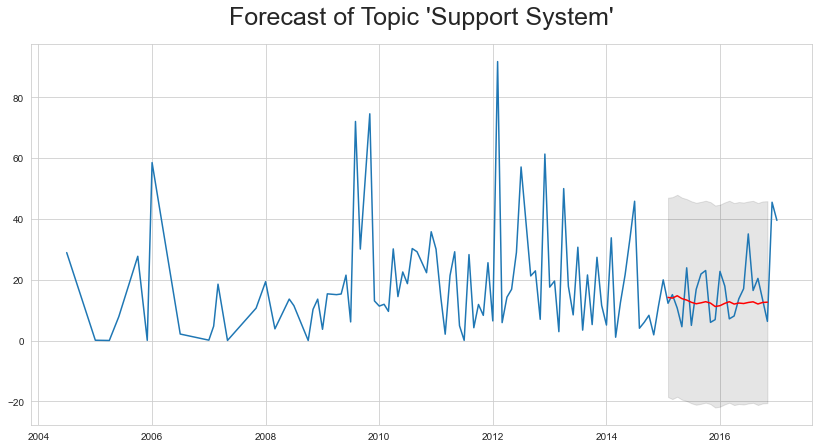


This is the forecast of the topic 'future':



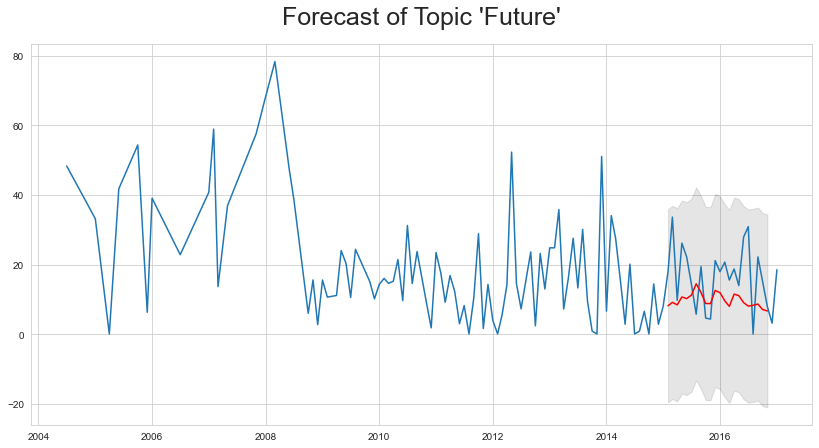


This is the forecast of the topic 'political ambitions':



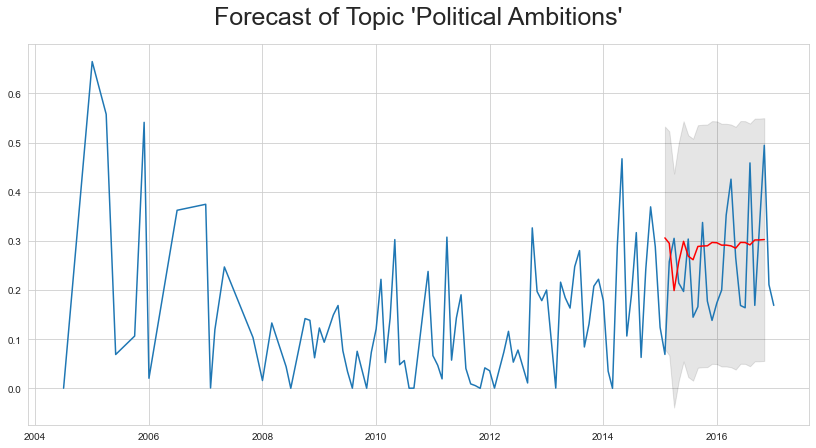

In [66]:
forecast_time_series(models_train)

### Diagnostics


These are the diagnostics plots of the topic 'defence':



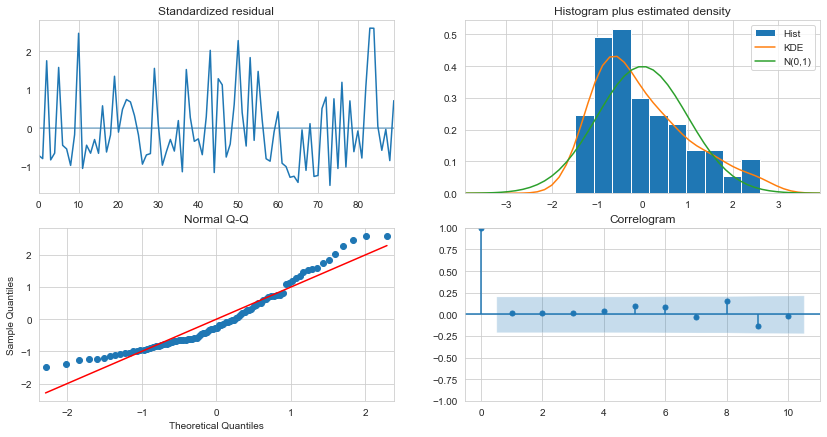


These are the diagnostics plots of the topic 'national pride':



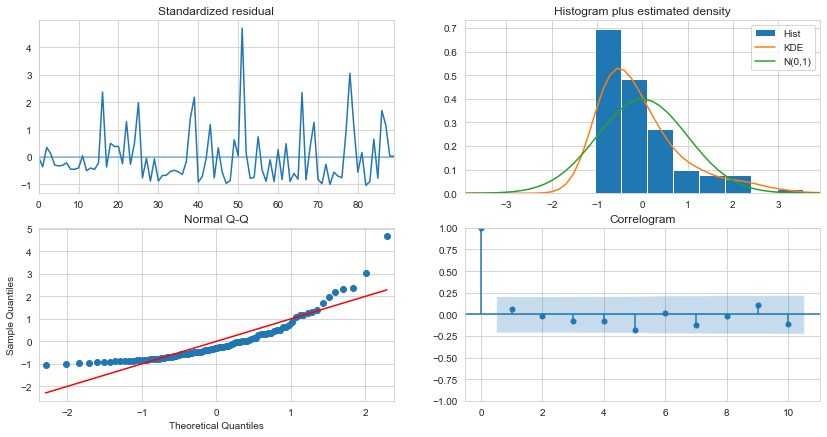


These are the diagnostics plots of the topic 'labour market':



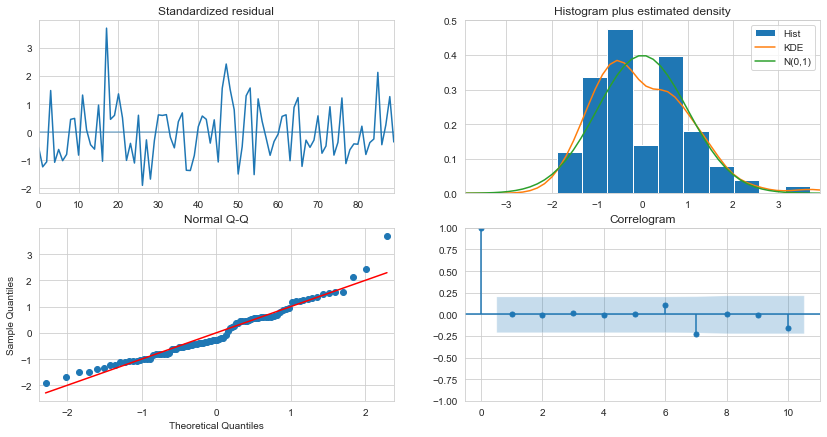


These are the diagnostics plots of the topic 'health care':



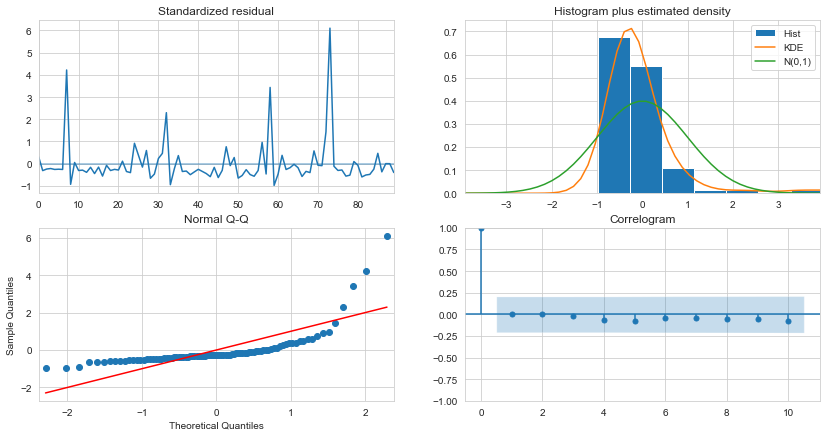


These are the diagnostics plots of the topic 'financial sector':



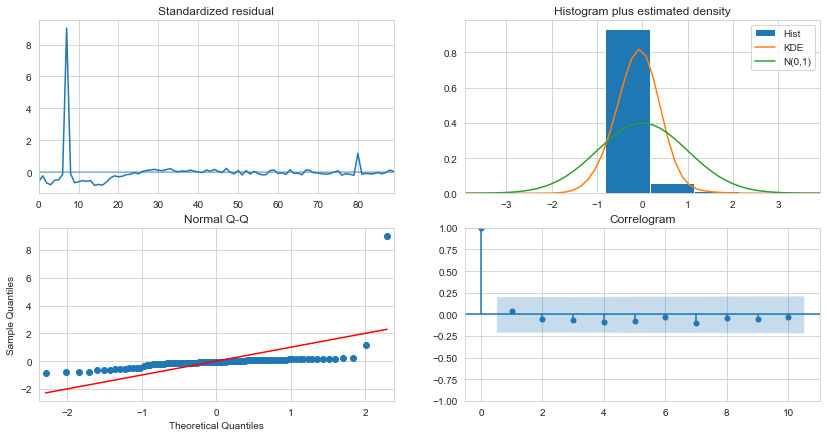


These are the diagnostics plots of the topic 'support system':



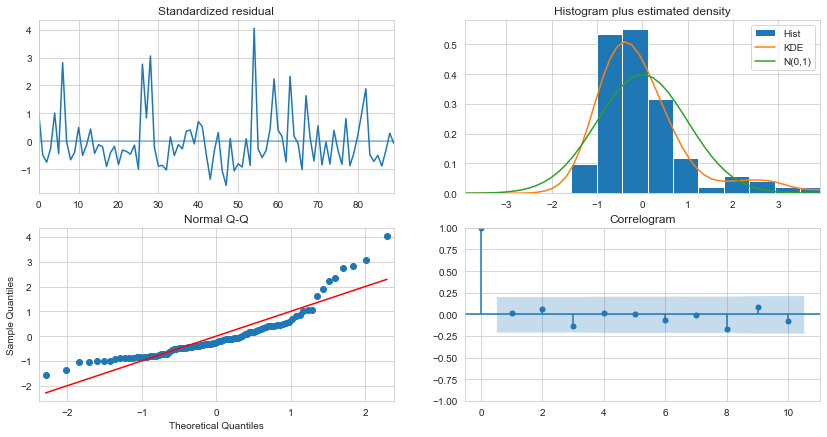


These are the diagnostics plots of the topic 'future':



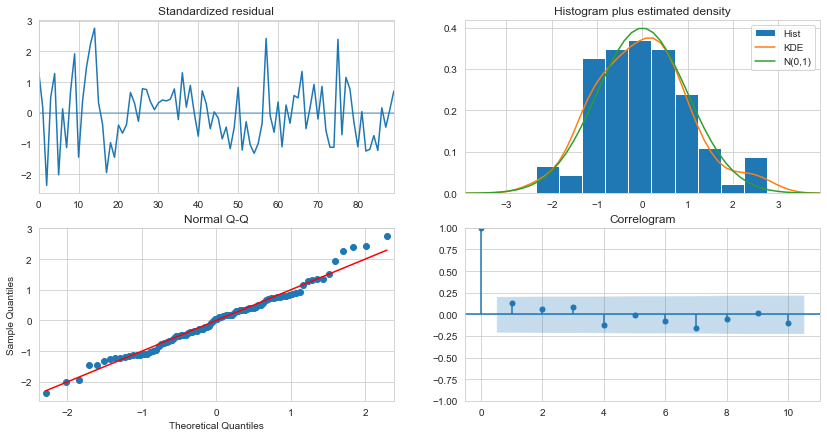


These are the diagnostics plots of the topic 'political ambitions':



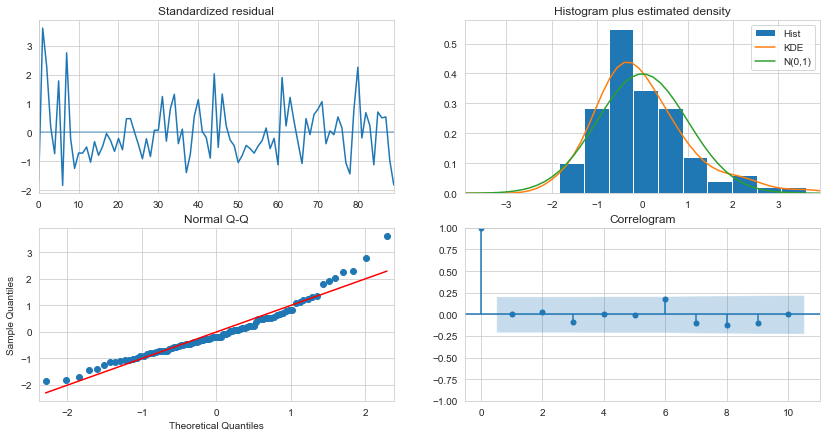

In [67]:
# show diagnostics plots for each topic
i = 0
for model in models_train:
    print("\nThese are the diagnostics plots of the topic '" + topic_names[i] + "':\n")
    model.plot_diagnostics()
    plt.show()
    i = i + 1

## Results

In [68]:
# standardise predictors in entire data set
time_series_df_standardised = time_series_df.copy()
time_series_df_standardised.iloc[:, number_topics:] = standardise_predictors(time_series_df_standardised.
                                                                             iloc[:, number_topics:])

In [69]:
# extract p, d and q from model with train data
pdq = []
for model in models_train:
    pdq.append(model.order)
    
# run time series analysis with entire data set using p, d, q from trained model
def time_series_entire(data_set, predictors):
    i = 0
    models_entire = []
    
    for column in data_set.columns[:number_topics]:
        model = ARIMA(data_set[column], 
                      order = pdq[i], 
                      exog = data_set[predictors])
    
        models_entire.append(model)
    
        i = i + 1
    
    return models_entire

In [70]:
models_entire = time_series_entire(time_series_df_standardised, predictors)

In [71]:
# extract coefficients and p-values for each topic
def coef_pvalue(models):
    i = 0
    for model in models:
        model_fit = model.fit()
        # write p-values and coefficients to data frames
        pvalues = pd.DataFrame(model_fit.pvalues)
        coef = pd.DataFrame(model_fit.params)
    
        # merge coefficients with p-values
        results = pd.merge(coef, pvalues, left_index = True, right_index = True)
        results.columns = ['coef', 'pvalues']
    
        # print output
        print("\nThis is the output of the time series analysis for the topic '" + str(topic_names[i]) + "':\n")
    
        print(results.round(4))
    
        i = i + 1

In [72]:
# print output for each topic
coef_pvalue(models_entire)


This is the output of the time series analysis for the topic 'defence':

                  coef  pvalues
const          16.1456   0.0000
unemployment    2.8703   0.0823
oil            -0.3407   0.8153
stocks          3.4275   0.0255
ar.L1          -0.0118   0.9010
ar.L2          -0.0664   0.5398
ar.L3          -0.0842   0.4124
ar.L4          -0.1418   0.2867
sigma2        184.6843   0.0000

This is the output of the time series analysis for the topic 'national pride':

                  coef  pvalues
const           9.4203   0.0000
unemployment    2.4660   0.1948
oil            -0.7183   0.5411
stocks          3.5389   0.0551
sigma2        114.0857   0.0000

This is the output of the time series analysis for the topic 'labour market':

                  coef  pvalues
const          17.2717   0.0000
unemployment    3.1745   0.1818
oil            -1.2259   0.5644
stocks         -3.8405   0.0747
ma.L1           0.1749   0.0662
sigma2        201.9566   0.0000

This is the output of the ti